# 1 Import libraries and load dataset

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools
import warnings
warnings.filterwarnings("ignore")


In [60]:
df = pd.read_csv('Airline customers.csv')
df.head()

,Month,#Passengers
0,2008-01-01,4704
1,2008-02-01,4956
2,2008-03-01,5544
3,2008-04-01,5418
4,2008-05-01,5082


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


# 2 Data preprocessing

In [62]:
# Convert 'Month' to datetime and set it as index
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d', errors='coerce')
df.set_index('Month', inplace=True)
df.rename(columns={'#Passengers': 'MonthlyPassengers'}, inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   MonthlyPassengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [64]:
df.isnull().sum()

MonthlyPassengers    0
dtype: int64

In [65]:
df.duplicated().sum()

26

There are no duplicates or missing values.

# 3 Exploratory Data Analysis

In [66]:
df.describe()

,MonthlyPassengers
count,144.000000
mean,11772.541667
std,5038.585312
min,4368.000000
25%,7560.000000
50%,11151.000000
75%,15141.000000
max,26124.000000


### Dynamics of target variable

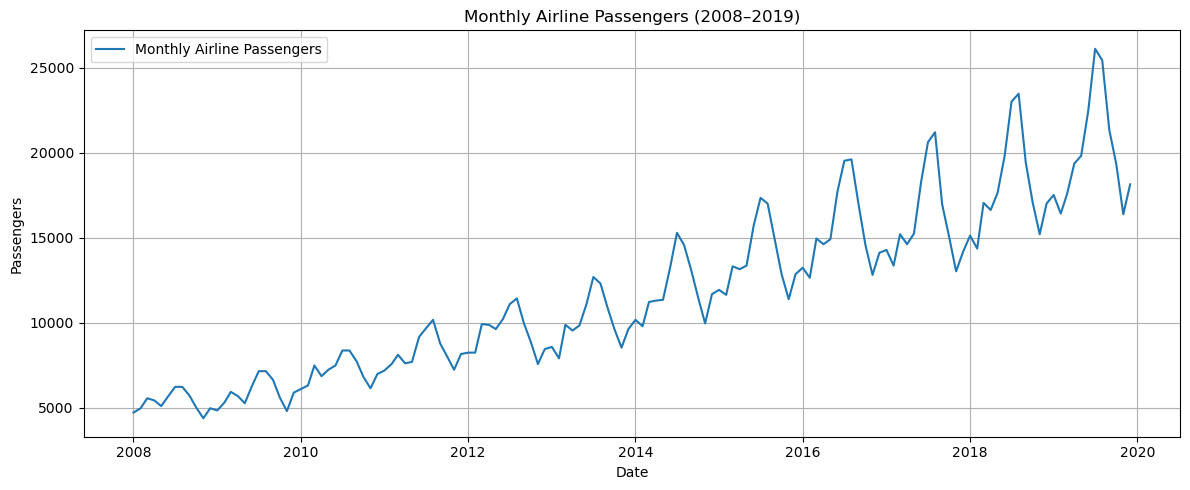

In [67]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['MonthlyPassengers'], label='Monthly Airline Passengers')
plt.title('Monthly Airline Passengers (2008–2019)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Check for trend, seasonality, and residuals in the  time series 

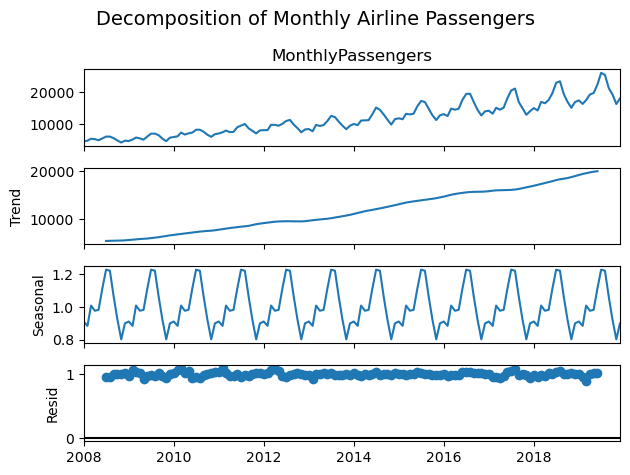

In [68]:
decomposition = seasonal_decompose(df['MonthlyPassengers'], model='multiplicative', period=12)
decomposition.plot()
plt.suptitle('Decomposition of Monthly Airline Passengers', fontsize=14)
plt.tight_layout()
plt.show()

- The decomposition reveals a well-defined trend and seasonal pattern, making this dataset highly suitable for models like SARIMA or Prophet.
- The residuals appear to be centered around zero with consistent variance. 
- Further modeling should account for both trend and seasonality to ensure accurate forecasting.

### Seasonal Patterns by Year and Month

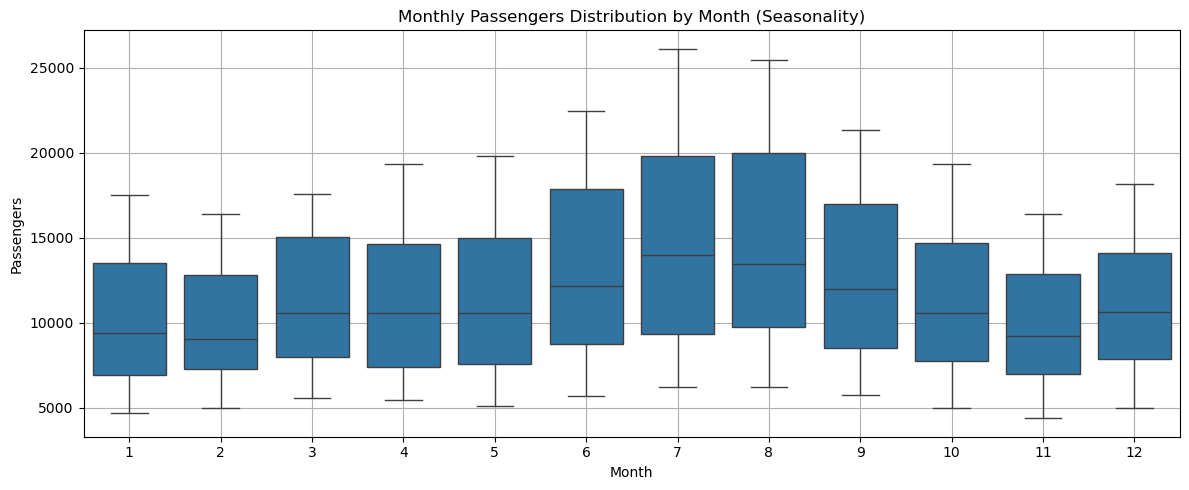

In [69]:
df['Year'] = df.index.year
df['Month'] = df.index.month

plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='Month', y='MonthlyPassengers')
plt.title("Monthly Passengers Distribution by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.grid(True)
plt.tight_layout()
plt.show()


- No extreme outliers are visibly marked, suggesting data is without significant anomalies for each month.
- Passenger numbers peak in July  and August — this aligns with the summer holiday season, where travel demand typically spikes. These months show both higher medians and greater variability, indicating a larger range of passenger volumes during peak seasons.
- February and November  have the lowest medians and narrower interquartile ranges. These months are likely part of the off-season for travel.

### Stationarity Check 

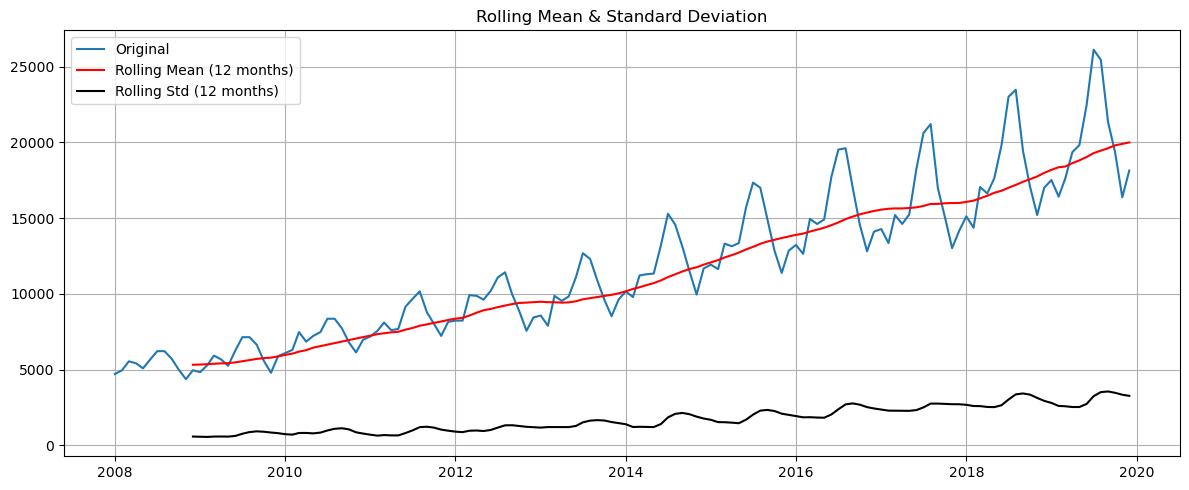

ADF Statistic: 0.8153688792061309
p-value: 0.9918802434376423
Critical Value 1%: -3.4816817173418295
Critical Value 5%: -2.8840418343195267
Critical Value 10%: -2.578770059171598


In [70]:
rolling_mean = df['MonthlyPassengers'].rolling(window=12).mean()
rolling_std = df['MonthlyPassengers'].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(df['MonthlyPassengers'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='red')
plt.plot(rolling_std, label='Rolling Std (12 months)', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test
result = adfuller(df['MonthlyPassengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')


Since p-value > 0.05, the original time series is non-stationary.

### Data Distribution

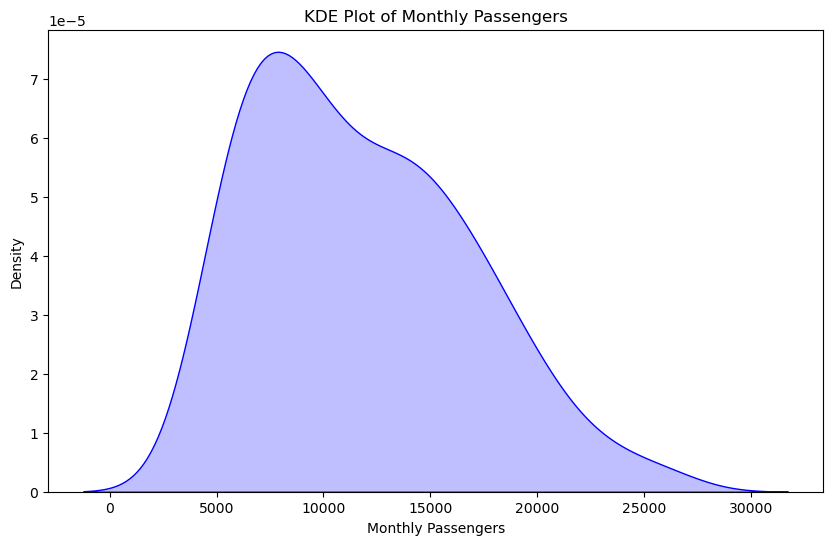

In [71]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['MonthlyPassengers'], shade=True, color='blue')
plt.title('KDE Plot of Monthly Passengers')
plt.xlabel('Monthly Passengers')
plt.ylabel('Density')
plt.show()

The distribution is right-skewed, with a long tail on the higher end. To address this skewness and improve model performance, applying a log transformation would be effective. The log transformation compresses the range of high values, reduces the skew, and helps stabilize variance, making the data more suitable for modeling and improving predictive accuracy.

### Log Transformation to stabilize variance 

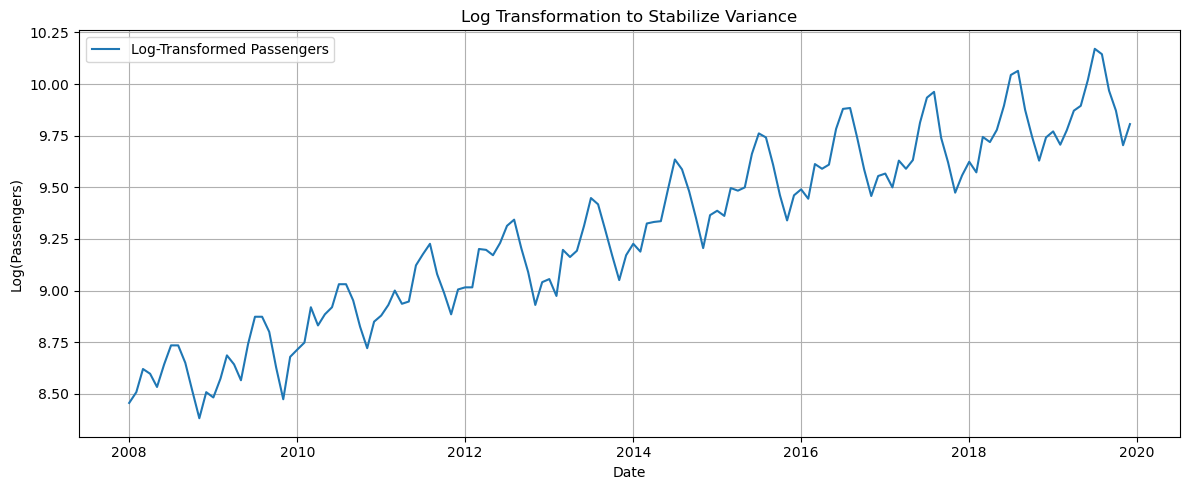

In [72]:
df['LogPassengers'] = np.log(df['MonthlyPassengers'])

plt.figure(figsize=(12, 5))
plt.plot(df['LogPassengers'], label='Log-Transformed Passengers')
plt.title('Log Transformation to Stabilize Variance')
plt.xlabel('Date')
plt.ylabel('Log(Passengers)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


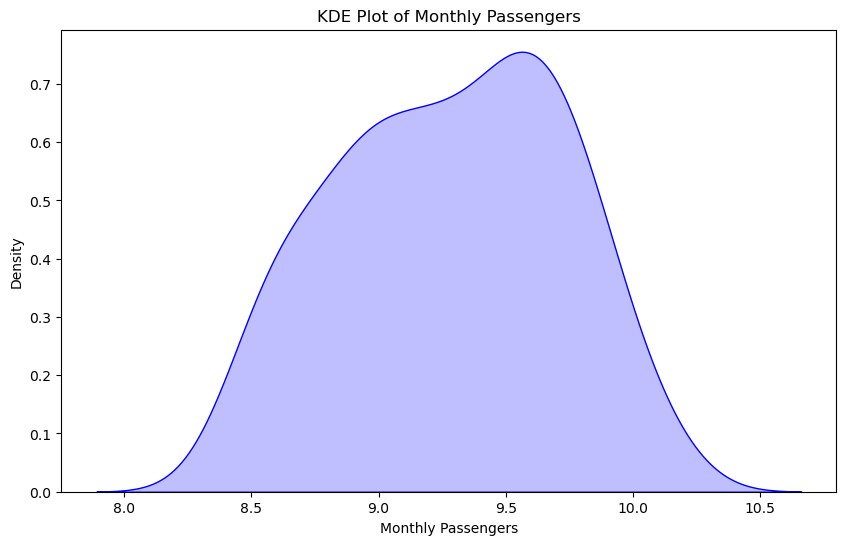

In [73]:
# Plot KDE for Monthly Passengers
plt.figure(figsize=(10, 6))
sns.kdeplot(df['LogPassengers'], shade=True, color='blue')
plt.title('KDE Plot of Monthly Passengers')
plt.xlabel('Monthly Passengers')
plt.ylabel('Density')
plt.show()

After the logarithm transformation, distribution appears more symmetrical, with reduced skewness.

### Differencing of target variable

Apply first-order difference to remove linear trend. 

Seasonal difference (lag 12): removes yearly seasonality

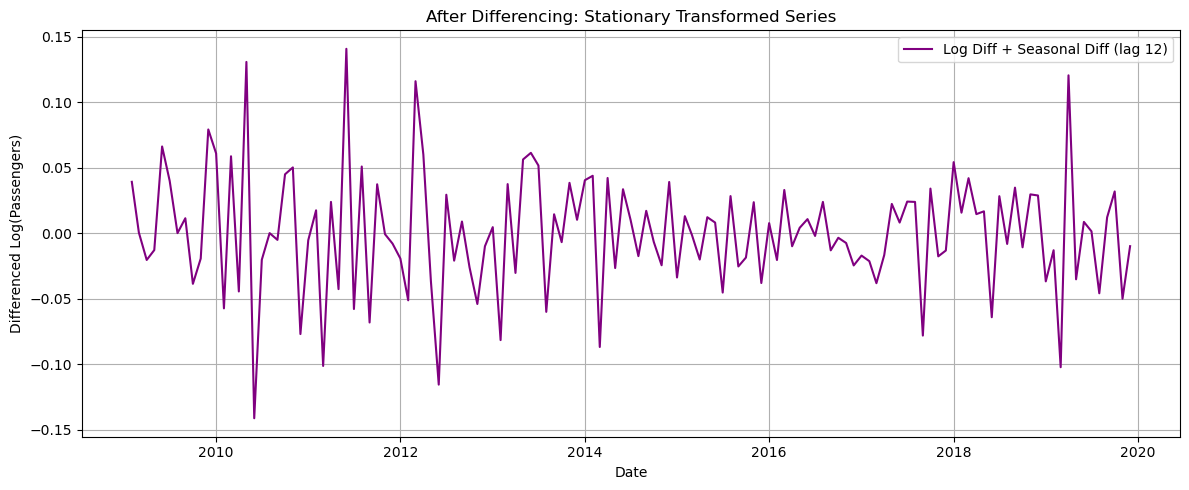

In [74]:
df['LogDiff'] = df['LogPassengers'].diff().dropna()
df['LogDiffSeasonal'] = df['LogDiff'].diff(12).dropna()

plt.figure(figsize=(12, 5))
plt.plot(df['LogDiffSeasonal'], label='Log Diff + Seasonal Diff (lag 12)', color='purple')
plt.title('After Differencing: Stationary Transformed Series')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Passengers)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Check for Stationarity after transformation using ADF Test

In [75]:
# Perform the ADF test on 'LogDiff'
result_diff2 = adfuller(df['LogDiff'].dropna())

# Output the ADF test results
print("ADF Statistic (after log + diff):", result_diff2[0])
print("p-value:", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic (after log + diff): -2.717130598388139
p-value: 0.07112054815085772
Critical Value 1%: -3.4825006939887997
Critical Value 5%: -2.884397984161377
Critical Value 10%: -2.578960197753906


In [76]:
# Perform the ADF test on 'LogDiff'
result_diff2 = adfuller(df['LogDiff'].diff().diff().dropna(), autolag='AIC')
# Output the ADF test results
print("ADF Statistic (after log + diff):", result_diff2[0])
print("p-value:", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic (after log + diff): -9.824010905497875
p-value: 5.2461332951720724e-17
Critical Value 1%: -3.4833462346078936
Critical Value 5%: -2.8847655969877666
Critical Value 10%: -2.5791564575459813


Since the p-value of the Augmented Dickey-Fuller (ADF) test is less than 0.05, we can reject the null hypothesis that the time series has a unit root (i.e., is non-stationary). This indicates that the nonseasonal part of the time series is stationary after 2nd-order differencing (d=2)

In [77]:
result_diff = adfuller(df['LogDiffSeasonal'].dropna())

print("ADF Statistic (after log + diff):", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic (after log + diff): -4.4433249418311425
p-value: 0.00024859123113838495
Critical Value 1%: -3.4870216863700767
Critical Value 5%: -2.8863625166643136
Critical Value 10%: -2.580009026141913


For the seasonal component, the series is stationary after 1st-order seasonal differencing (D=1) with a seasonal period of 12 (s=12). 
At this stage, we can expect one or few of the following parameters for the SARIMA model:

d=2: Nonseasonal differencing of order 2.

D=1: Seasonal differencing of order 1.

s=12: Seasonal period of 12.

In [78]:
log_series = df['LogPassengers']
log_diff = log_series.diff().dropna()

# Seasonal differencing (12-month lag)
log_diff_seasonal = log_diff.diff(12).dropna()

<Figure size 1200x400 with 0 Axes>

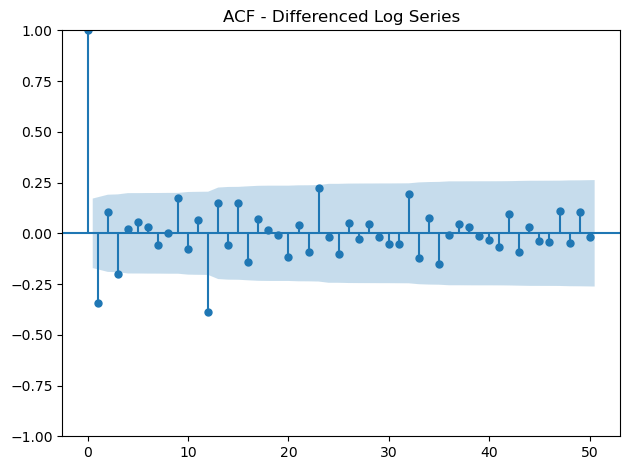

<Figure size 1200x400 with 0 Axes>

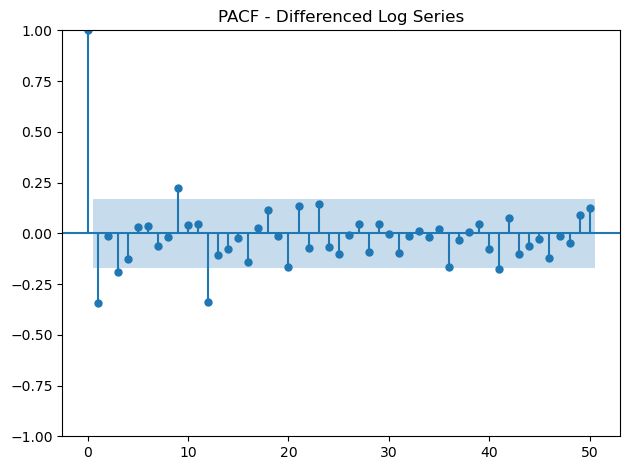

In [79]:
# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(log_diff_seasonal, lags=50)
plt.title('ACF - Differenced Log Series')
plt.tight_layout()
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(log_diff_seasonal, lags=50)
plt.title('PACF - Differenced Log Series')
plt.tight_layout()
plt.show()

- From the PACF plot, there is a significant partial autocorrelation at lag 1 in the seasonal differenced series. This suggests that P = 1 possible for the seasonal AR order.
- From the ACF plot, there is a significant autocorrelation at lag 1 in the seasonal differenced series, indicating possible Q = 1 for the seasonal MA order.

# 4 SARIMA Model

SARIMA(p,d,q)(P,D,Q)[s]

p: Uses n previous value

d: n non-seasonal difference (remove trend)

q: n previous error term

P: n seasonal lag (e.g., uses value from 12 months ago)

D: seasonal differencing (difference from 12 months ago)

Q: n seasonal error term

s=12: yearly seasonality in monthly data

### Splitting the data

In [80]:
train = log_series.iloc[:-24]
test = log_series.iloc[-24:]

### Finding the optimal values for the SARIMAX model components

In [81]:
auto_arima(train, m=12, seasonal=True, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-386.375, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-277.702, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-381.231, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-341.622, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.985, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-389.777, Time=1.23 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-365.957, Time=0.58 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-387.750, Time=3.31 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-383.803, Time=1.07 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-385.835, Time=2.91 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-390.768, Time=0.54 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-366.343, Time=0.38 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-386.812, Time=1.14 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-388.941, Time=2.67 sec
 ARIMA(1,0,2)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 201.768
Date:                              Tue, 22 Apr 2025   AIC                           -393.537
Time:                                      15:25:35   BIC                           -380.126
Sample:                                  01-01-2008   HQIC                          -388.099
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0180      0.010      1.811      0.070      -0.001       0.038
ar.L1          0.6165      0.088      6.975      0.000       0.443       0.790
ar.L2          0.2342      0.092      2.532      0.011       0.053       0.415
ma.S.L12      -0.5557      0.120     -4.619      0.000      -0.791      -0.320
sigma2         0.0013      0.000      7.469      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.51
Prob(Q):                              1.00   Prob(JB):                         0.17
Heteroskedasticity (H):               0.40   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model (2,0,0)x(0,1,1,12) shows good quality however intercept is not statistically significant.

### Training model (1 model)

In [82]:
model1 = SARIMAX(train,
                order=(2, 0, 0),          
                seasonal_order=(0, 1, 1, 12),  
                enforce_stationarity=False,
                enforce_invertibility=False)
results1 = model1.fit()
print(results1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27895D+00    |proj g|=  3.97717D+00

At iterate    5    f= -1.30223D+00    |proj g|=  3.58846D+00

At iterate   10    f= -1.45698D+00    |proj g|=  4.94555D+00

At iterate   15    f= -1.48026D+00    |proj g|=  1.48243D-02

At iterate   20    f= -1.48027D+00    |proj g|=  4.02453D-02


 This problem is unconstrained.



At iterate   25    f= -1.48034D+00    |proj g|=  7.60966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     75      2     0     0   7.201D-03  -1.480D+00
  F =  -1.4803365543286640     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                      SARIMAX Results                                       
Dep. Variable:                        LogPassengers   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 177.640
Date:                              Tue, 22 Apr 2025   AIC                         


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


This SARIMA model (without intercept) shows a good fit with reasonably significant AR terms and a strong seasonal MA component. The AIC, BIC, and HQIC values suggest that this is a well-fitting model.

The model does not show significant autocorrelation or non-normality in the residuals.

#### Forecat evaluation metrics

In [83]:
forecast_log1 = results1.get_forecast(steps=24)
forecast1 = np.exp(forecast_log1.predicted_mean) 
actual1 = np.exp(test) 
rmse1 = np.sqrt(mean_squared_error(actual1, forecast1))

mae1 = mean_absolute_error(actual1, forecast1)
mape1 = np.mean(np.abs((actual1 - forecast1) / actual1)) * 100

print("📉 Forecast Evaluation on Test Set:")
print(f"RMSE: {rmse1:.2f}")
print(f"MAE : {mae1:.2f}")
print(f"MAPE: {mape1:.2f}%")

📉 Forecast Evaluation on Test Set:
RMSE: 2334.82
MAE : 2134.32
MAPE: 10.96%


MAPE 10.96% indicates the model's predictions are off by 10.96% on average.
This metric suggests room for improvement, and the model will be optimized to reduce the MAPE for better forecast accuracy.

### Optimizing grid search with fixed parameters

In [84]:
# Fix d=1, D=0, s=12
d = 1
D = 0
s = 12

p = q = P = Q = [0, 1, 2]
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(x[0], D, x[1], s) for x in itertools.product(P, Q)]

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

print("Running optimized grid search...\n")

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
            print(f"SARIMA{order}x{seasonal_order}12 - AIC: {results.aic:.2f}")
        except:
            continue

print("\n✅ Best SARIMA Parameters:")
print(f"Order (p,d,q): {best_order}")
print(f"Seasonal Order (P,D,Q,s): {best_seasonal_order}")
print(f"Best AIC: {best_aic:.2f}")


Running optimized grid search...

SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC: -192.46
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC: -238.56
SARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC: -249.93
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC: -354.07
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC: -374.39
SARIMA(0, 1, 0)x(1, 0, 2, 12)12 - AIC: -323.35
SARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC: -328.96
SARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC: -327.70
SARIMA(0, 1, 0)x(2, 0, 2, 12)12 - AIC: -334.08
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC: -194.70
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC: -236.14
SARIMA(0, 1, 1)x(0, 0, 2, 12)12 - AIC: -247.50
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC: -363.29
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC: -378.32
SARIMA(0, 1, 1)x(1, 0, 2, 12)12 - AIC: -329.33
SARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC: -341.75
SARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC: -339.75
SARIMA(0, 1, 1)x(2, 0, 2, 12)12 - AIC: -342.45
SARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC: -194.02
SARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC: -230.48
SARIMA(0, 1, 2)x(0, 0, 2, 

### Train SARIMA model (2)

In [85]:
model = SARIMAX(train,
                order=(1, 1, 0),          
                seasonal_order=(1, 0, 1, 12),  
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09675D+00    |proj g|=  7.03253D+00

At iterate    5    f= -1.54533D+00    |proj g|=  5.80804D-01

At iterate   10    f= -1.62434D+00    |proj g|=  8.68155D-01

At iterate   15    f= -1.62564D+00    |proj g|=  1.93689D-02

At iterate   20    f= -1.62584D+00    |proj g|=  6.50611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     43      1     0     0   6.506D-03  -1.626D+00
  F =  -1.6258400286975809     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                      SARIMAX Results                                       
Dep. Variable:                        LogPassengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 195.101
Date:                              Tue, 22 Apr 2025   AIC                           -382.202
Time:                                      15:26:16   BIC                           -371.548
Sample:                                  01-01-2008   HQIC                          -377.884
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3172      0.078     -4.068      0.000      -0.470      -0.164
ar.S.L12       1.00

Based on the analysis, Model 2 fits the data better than Model 1, as evidenced by its lower AIC, BIC, and HQIC values. These lower values indicate that Model 2 is more efficient in explaining the data, potentially leading to better generalization.

Given that Model 2 outperforms Model 1 in terms of fit quality, the analysis will continue using SARIMA Model 2 for further modeling and forecasting.

#### Residual analysis

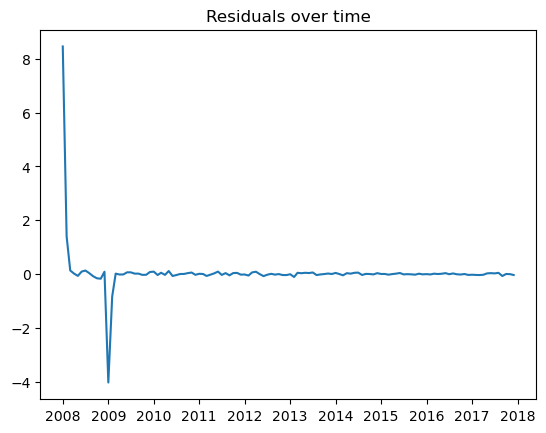

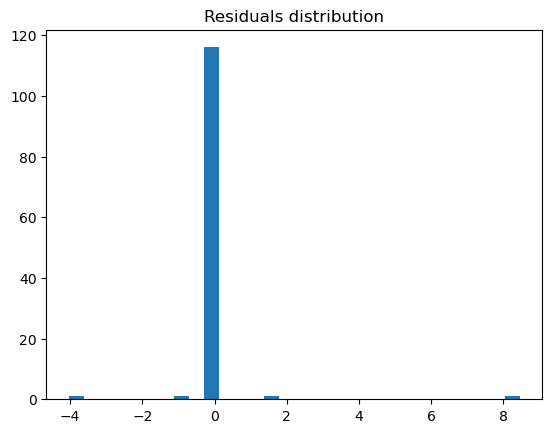

In [86]:
residuals = results.resid
plt.plot(residuals)
plt.title("Residuals over time")
plt.show()

plt.hist(residuals, bins=30)
plt.title("Residuals distribution")
plt.show()

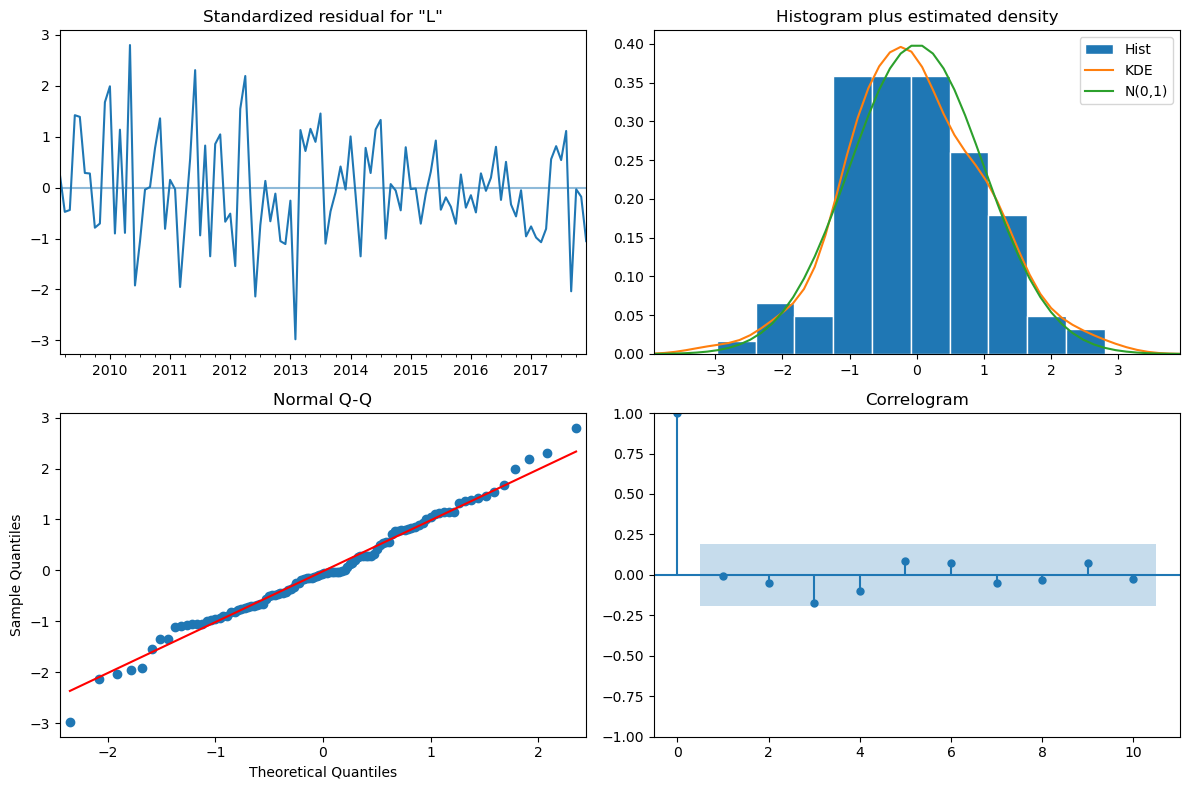

In [87]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

Analysis suggested that residuals:
- hover around 0 with no obvious patterns. No major autocorrelation or trend remains.
- approximately follow a normal distribution, which supports the assumptions of the model.
-  approximately normally distributed.
- are uncorrelated, so the model has likely captured all time-dependent structure.

#### Ljung-Box test on the residuals

In [88]:
lags = 10
ljung_box_results = acorr_ljungbox(residuals, lags=lags)

print("Ljung-Box Test Results:")
print(ljung_box_results)

Ljung-Box Test Results:
     lb_stat  lb_pvalue
1   3.454909   0.063064
2   3.508400   0.173046
3   3.525075   0.317524
4   3.525618   0.473994
5   3.535635   0.618003
6   3.540383   0.738589
7   3.541247   0.830838
8   3.546760   0.895530
9   3.571236   0.937305
10  3.617173   0.962969


There is no significant autocorrelation detected in the residuals for any of the tested lags. This suggests that the model has adequately captured the dependencies in the data, and the residuals appear to be random.

#### Forecat evaluation metrics

In [89]:
forecast_log = results.get_forecast(steps=24)
forecast = np.exp(forecast_log.predicted_mean) 
actual = np.exp(test) 

In [90]:
rmse = np.sqrt(mean_squared_error(actual, forecast))
mae = mean_absolute_error(actual, forecast)
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print("📉 Forecast Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


📉 Forecast Evaluation on Test Set:
RMSE: 1789.49
MAE : 1644.53
MAPE: 8.49%


The model's predictions are, on average, off by 8.49% from the actual values.  
Given the lower MAPE and overall reduced error metrics (RMSE and MAE), Model 2 is the preferred model for forecasting compared to Model 1. 

### Confidence intervals

In [91]:
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# Inverse transform from log if needed
forecast_mean = np.exp(forecast_mean_log)
conf_int = np.exp(conf_int_log)

df_forecast = pd.DataFrame({
    'MonthlyPassengers': df['MonthlyPassengers'],
    'Forecast': forecast_mean,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
}, index=forecast_mean.index)

df_forecast = df_forecast.round(0)
print(df_forecast)

            MonthlyPassengers  Forecast  Lower CI  Upper CI
2018-01-01              15120   14620.0   13581.0   15738.0
2018-02-01              14364   13862.0   12678.0   15155.0
2018-03-01              17052   16083.0   14462.0   17887.0
2018-04-01              16632   15632.0   13867.0   17622.0
2018-05-01              17640   16063.0   14072.0   18335.0
2018-06-01              19824   19039.0   16492.0   21981.0
2018-07-01              23016   21349.0   18299.0   24908.0
2018-08-01              23478   21505.0   18252.0   25337.0
2018-09-01              19446   18047.0   15176.0   21461.0
2018-10-01              17094   15783.0   13156.0   18935.0
2018-11-01              15204   13730.0   11349.0   16611.0
2018-12-01              17010   15228.0   12486.0   18572.0
2019-01-01              17514   15637.0   12580.0   19437.0
2019-02-01              16422   14849.0   11783.0   18712.0
2019-03-01              17598   17237.0   13488.0   22029.0
2019-04-01              19362   16753.0 

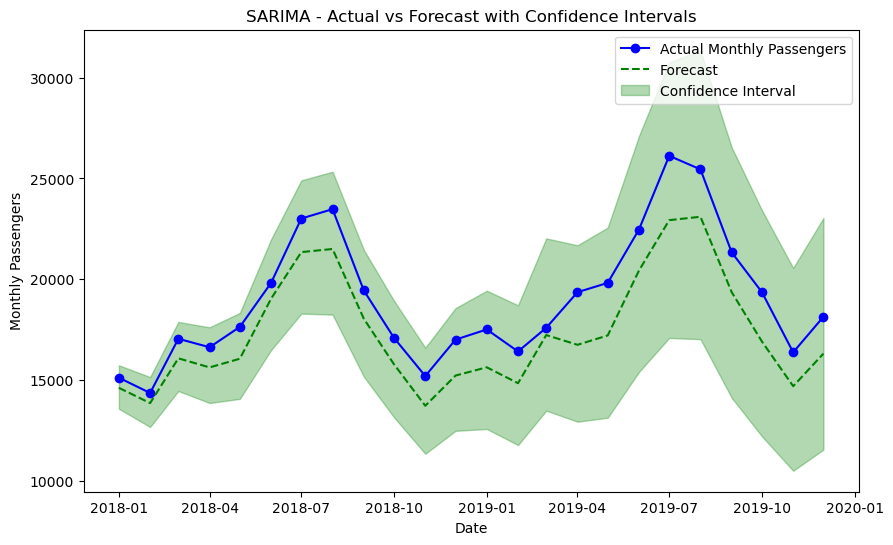

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(df_forecast.index, df_forecast['MonthlyPassengers'], label='Actual Monthly Passengers', color='blue', marker='o')

plt.plot(df_forecast.index, df_forecast['Forecast'], label='Forecast', color='green', linestyle='--')

plt.fill_between(df_forecast.index, df_forecast['Lower CI'], df_forecast['Upper CI'], color='green', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Monthly Passengers')
plt.title('SARIMA - Actual vs Forecast with Confidence Intervals')
plt.legend()
plt.show()

### Plot the forecast vs. actual

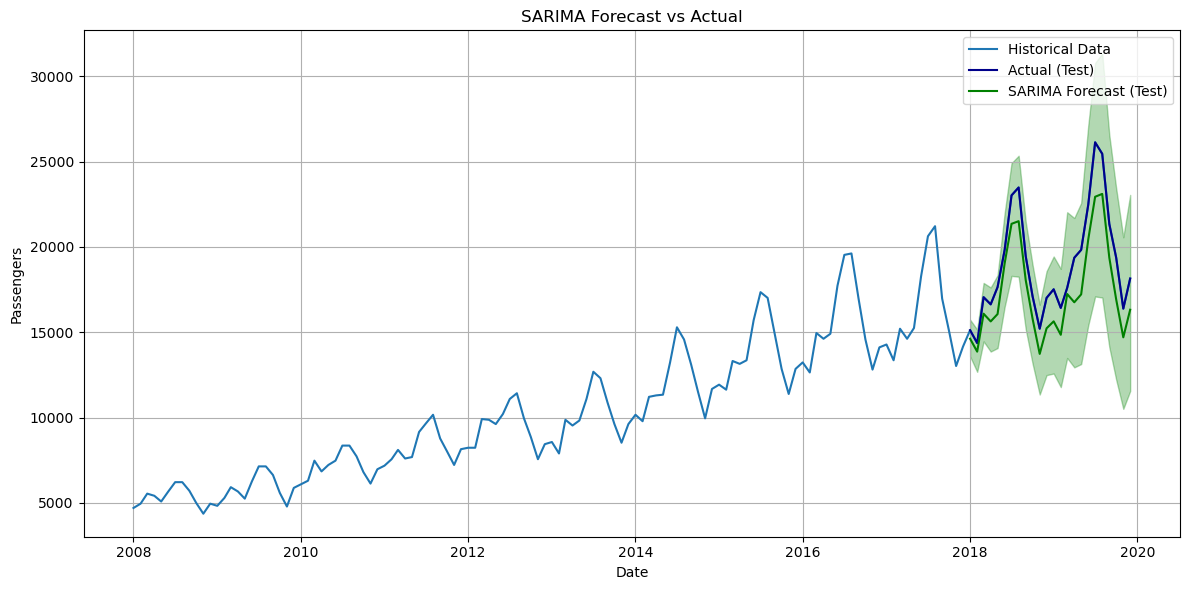

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MonthlyPassengers'], label='Historical Data')
plt.plot(actual.index, actual, label='Actual (Test)', color='darkblue')
plt.plot(forecast.index, forecast, label='SARIMA Forecast (Test)', color='green')
plt.fill_between(forecast.index,
                 np.exp(forecast_log.conf_int().iloc[:, 0]),
                 np.exp(forecast_log.conf_int().iloc[:, 1]),
                 color='green', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The model successfully captures the underlying patterns in the data, although it exhibits a slight tendency to underestimate projected values. Additionally, the confidence interval widens over time, reflecting increasing uncertainty in longer-term forecasts.

# 5 Prophet model

In [94]:
df2 = df.copy()
df2.head()

,MonthlyPassengers,Year,Month,LogPassengers,LogDiff,LogDiffSeasonal
Month,,,,,,
2008-01-01,4704,2008,1,8.456168,NaN,NaN
2008-02-01,4956,2008,2,8.508354,0.052186,NaN
2008-03-01,5544,2008,3,8.620472,0.112117,NaN
2008-04-01,5418,2008,4,8.597482,-0.022990,NaN
2008-05-01,5082,2008,5,8.533460,-0.064022,NaN


In [95]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MonthlyPassengers  144 non-null    int64  
 1   Year               144 non-null    int32  
 2   Month              144 non-null    int32  
 3   LogPassengers      144 non-null    float64
 4   LogDiff            143 non-null    float64
 5   LogDiffSeasonal    131 non-null    float64
dtypes: float64(3), int32(2), int64(1)
memory usage: 10.8 KB


### Preparing the data

In [96]:
df2 = df2.rename(columns={ 'MonthlyPassengers': 'y'})
df2.drop(columns=['Year', 'Month', 'LogPassengers', 'LogDiff', 'LogDiffSeasonal'], inplace=True)

df2.reset_index(inplace=True)

# Rename the 'Month' column to 'ds' for Prophet
df2 = df2.rename(columns={'Month': 'ds', 'MonthlyPassengers': 'y'})

df2['ds'] = pd.to_datetime(df2['ds'])
df2.head()

,ds,y
0,2008-01-01,4704
1,2008-02-01,4956
2,2008-03-01,5544
3,2008-04-01,5418
4,2008-05-01,5082


In [97]:
df2.dtypes

ds    datetime64[ns]
y              int64
dtype: object

### Splitting the data

In [98]:
train2 = df2.iloc[:-24]
test2 = df2.iloc[-24:]

In [99]:
train2['y'] = np.log(train2['y'] + 1) 

### Train the Prophet model

In [100]:
model2 = Prophet(
    interval_width=0.95, 
    yearly_seasonality=True,
    seasonality_mode='multiplicative')

model2.fit(train2)

15:26:19 - cmdstanpy - INFO - Chain [1] start processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
future_dates = model2.make_future_dataframe(periods=24, freq='MS')
future_dates.tail()

,ds
139,2019-08-01
140,2019-09-01
141,2019-10-01
142,2019-11-01
143,2019-12-01


### Forecast test set and confidence intervals

In [102]:
forecast2 = model2.predict(future_dates)
forecast2['yhat'] = np.exp(forecast2['yhat']) - 1
forecast2['yhat_lower'] = np.exp(forecast2['yhat_lower']) - 1  
forecast2['yhat_upper'] = np.exp(forecast2['yhat_upper']) - 1  

# Combine the actual values from the test set with the forecasted values
result_df = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test2)) 

result_df['y_actual'] = test2['y'].values
print(result_df)

            ds          yhat    yhat_lower    yhat_upper  y_actual
120 2018-01-01  15122.503703  14212.883209  16060.117518     15120
121 2018-02-01  14915.189292  13985.428786  15810.123363     14364
122 2018-03-01  17321.539930  16295.902217  18395.458290     17052
123 2018-04-01  16572.480466  15548.943941  17629.164144     16632
124 2018-05-01  16702.357610  15723.241592  17800.054514     17640
125 2018-06-01  19311.922725  18150.613796  20600.744549     19824
126 2018-07-01  21455.657205  19999.922612  22938.194299     23016
127 2018-08-01  21283.363125  19878.978983  22820.577687     23478
128 2018-09-01  18483.445915  17257.599411  19806.931983     19446
129 2018-10-01  16014.518950  14891.870036  17281.669409     17094
130 2018-11-01  13907.251810  12835.135197  15066.892849     15204
131 2018-12-01  15826.841417  14487.621483  17153.469453     17010
132 2019-01-01  16152.554604  14764.375185  17524.765738     17514
133 2019-02-01  16063.008741  14528.512059  17667.084017     1

### Plotting the actual vs predicted values

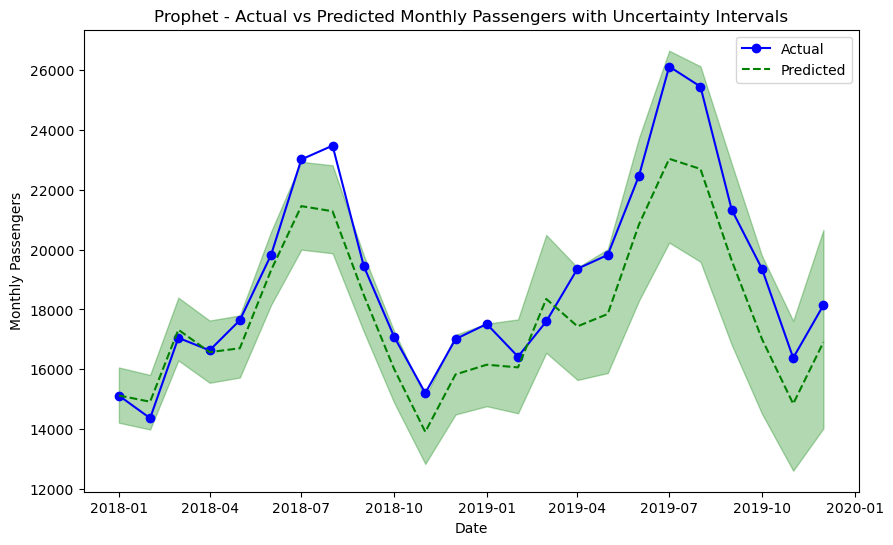

In [104]:
plt.figure(figsize=(10, 6))

plt.plot(result_df['ds'], result_df['y_actual'], label='Actual', color='blue', marker='o')

# Plot the predicted values from the forecast (yhat)
plt.plot(result_df['ds'], result_df['yhat'], label='Predicted', color='green', linestyle='--')

# Plot the uncertainty intervals (yhat_lower, yhat_upper)
plt.fill_between(result_df['ds'], result_df['yhat_lower'], result_df['yhat_upper'], color='green', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Monthly Passengers')
plt.title('Prophet - Actual vs Predicted Monthly Passengers with Uncertainty Intervals')
plt.legend()
plt.show()

The predicted trend closely mirrors the actual values, particularly in capturing seasonal patterns and key inflection points, such as the mid-2018 and mid-2019 peaks. This alignment indicates that the Prophet model has effectively learned both the trend and seasonal components of the time series. However, starting from periods 7 and 8, the actual values fall outside the model’s confidence intervals, suggesting potential underestimation of uncertainty

#### Forecat evaluation metrics

In [105]:
y_true = test2['y'].values

y_pred = forecast2['yhat'][-len(test2):].values

# MAE (Mean Absolute Error)
mae2 = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse2 = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape2 = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae2}")
print(f"RMSE: {rmse2}")
print(f"MAPE: {mape2}%")

MAE: 1303.0986699933967
RMSE: 1529.701416900605
MAPE: 6.53714513138985%


On average, the model's predictions are off by 6.54% relative to the actual values. 

### Cross-validation of Prophet model

In [ ]:
df_cv = cross_validation(
    model2,
    initial='1095 days',  
    period='180 days',  
    horizon='365 days' 
)

df_metrics = performance_metrics(df_cv)

print("Performance Metrics:")
print(df_metrics.head())

  0%|          | 0/13 [00:00<?, ?it/s]

15:26:20 - cmdstanpy - INFO - Chain [1] start processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:21 - cmdstanpy - INFO - Chain [1] start processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:21 - cmdstanpy - INFO - Chain [1] start processing
15:26:22 - cmdstanpy - INFO - Chain [1] done processing
15:26:22 - cmdstanpy - INFO - Chain [1] start processing
15:26:22 - cmdstanpy - INFO - Chain [1] done processing
15:26:22 - cmdstanpy - INFO - Chain [1] start processing
15:26:23 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing
15:26:23 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing
15:26:24 - cmdstanpy - INFO - Chain [1] done processing
15:26:24 - cmdstanpy - INFO - Chain [1] start processing
15:26:25 - cmdstanpy - INFO - Chain [1] done processing
15:26:25 - cmdstanpy - INFO - Chain [1] start processing
15:26:25 - cmdstanpy - INFO - Chain [1]

Performance Metrics:
  horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.003051  0.055236  0.046578  0.004985  0.004573  0.004987   
1 41 days  0.004918  0.070129  0.055265  0.005954  0.004573  0.005945   
2 42 days  0.004908  0.070056  0.055193  0.005941  0.004573  0.005935   
3 46 days  0.004871  0.069793  0.053720  0.005778  0.004573  0.005773   
4 47 days  0.004098  0.064013  0.047300  0.005097  0.004394  0.005087   

   coverage  
0  0.466667  
1  0.466667  
2  0.466667  
3  0.466667  
4  0.533333  


The model shows consistent performance with very low errors, especially in terms of MSE, RMSE, MAE, and the percentage error metrics (MAPE, MDAPE, SMAPE).

The slight increase in error metrics with the forecast horizon is typical for time series forecasting, as uncertainty grows with time.

The coverage is relatively stable, with a slight improvement for the longest horizon.

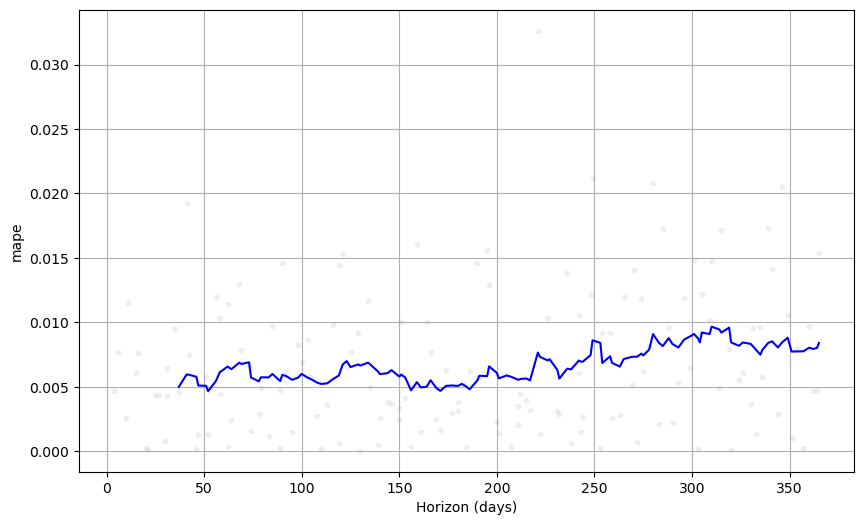

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

The MAPE increases as the forecast horizon extends (from 5% to 10%), which is typical in time series forecasting. The model captures short-term trends well but struggles to maintain accuracy over longer horizons. Overall, the model performs quite well and is stable across different forecast horizons.

# Conclusions

### Compare models SARIMA vs. Prophet

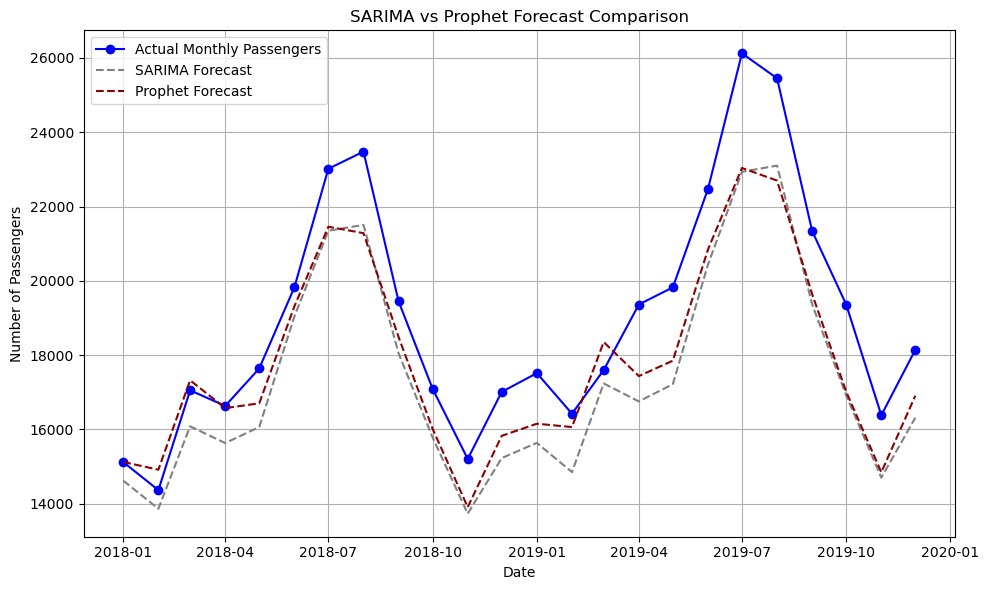

In [114]:
plt.figure(figsize=(10, 6))
# Actual values
plt.plot(df_forecast.index, df_forecast['MonthlyPassengers'], label='Actual Monthly Passengers', color='blue', marker='o')

# SARIMA forecast
plt.plot(df_forecast.index, df_forecast['Forecast'], label='SARIMA Forecast', color='grey', linestyle='--')

# Prophet forecast
plt.plot(result_df['ds'], result_df['yhat'], label='Prophet Forecast', color='darkred', linestyle='--')

plt.title('SARIMA vs Prophet Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Compared to the SARIMA model, Prophet demonstrates stronger performance in the initial six forecasted periods, aligning more tightly with observed values. 

In [ ]:
print("Model Performance Comparison:")
print("-" * 40)
print(f"{'Metric':<10} {'SARIMA':>10} {'Prophet':>10}")
print("-" * 40)
print(f"{'MAE':<10} {mae:10.2f} {mae2:10.2f}")
print(f"{'RMSE':<10} {rmse:10.2f} {rmse2:10.2f}")
print(f"{'MAPE':<10} {mape:10.2f}% {mape2:10.2f}%")
print("-" * 40)


Model Performance Comparison:
----------------------------------------
Metric         SARIMA    Prophet
----------------------------------------
MAE           1644.53    1303.10
RMSE          1789.49    1529.70
MAPE             8.49%       6.54%
----------------------------------------


Prophet model outperformed SARIMA across all evaluation metrics:

- ~21% lower MAE (better average error)

- ~15% lower RMSE (less penalty for large errors)

- ~2% better MAPE (more accurate relative to actual values)

These results suggest that Prophet provides a more accurate and robust forecast for this time series dataset.